# Dynamic Relational Inference in Multi-Agent Trajectories

## Introduction

Causal Structure Discovery (CSD) is the problem of identifying causal relationships from large quantities of data through computational methods. Causal relations cannot be read directly from a data sample, they can only be inferred. Causal relations are of intrests because only an understanding of the underlying causal relations can support predictions about how a system will behave when it is subject to intervention. Causal discovery has wide range of applications from climate modeling, social dynamics to biological systems modeling. Time series data play an important roles in many scientfic inquiry. Changing climate patterns, fMRI data, social dynamics and many other domains hold time series data at its core. In time-series, the assumption that causes temporrally precede thier effect enable us to discover causal relations in observational data.

In this article we will study the recent works done in causal discovery and implement a computational model to study and infer its behaviour. We will be first formally define the problem then explore methods of disovery.

## Background

We will first formall define a causal graph $G$ which is described by variables $V$ and edges $E$.





In [40]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import numpy as np

# Exploratory Data Analysis

First lets load all the data and split them into training and testing data set.

In [43]:
data = pd.read_pickle('../data/samples/dyari.pkl')
train = data.sample(frac=0.8, random_state=200)
test = data.drop(train.index)
print(len(train))

40


In [68]:
t = [0, 4, 5]
simulation_samples = train.iloc[t]
print(len(simulation_samples))
t0_positions = simulation_samples.trajectories[0].positions
t1_positions = simulation_samples.trajectories[1].positions
t2_positions = simulation_samples.trajectories[2].positions
print(t0_positions[0])
print(t0_positions[1])

3
             particle_0  particle_1
x_cordinate    0.933779   -0.488639
y_cordinate    0.475044   -0.075679
             particle_0  particle_1
x_cordinate    0.903944   -0.474342
y_cordinate    0.515410   -0.027283


In [63]:
# Lets pick one simulatated trajectory and analyze it
simulation_sample = train.iloc[0]

# For this simulation sample, lets get all positions
positions = simulation_sample.trajectories.positions
velocities = simulation_sample.trajectories.velocity
edges = simulation_sample.trajectories.edges

# Lets inspect elements at time step 0
print('position of all particles at time step 0')
print(positions[0], '\n')

print('velocity of all particles at time step 0')
print(velocities[0], '\n')

print('causality matrix of all particles at time step 0')
print(edges[0])

position of all particles at time step 0
             particle_0  particle_1
x_cordinate    0.933779   -0.488639
y_cordinate    0.475044   -0.075679 

velocity of all particles at time step 0
             particle_0  particle_1
x_cordinate   -0.291236    0.135858
y_cordinate    0.406425    0.481189 

causality matrix of all particles at time step 0
            particle_0  particle_1
particle_0         0.0         1.0
particle_1         1.0         0.0


We can see that the dataframe have x and y coordinates for all particles. Similarly we can extract velocities, edges and energy for all praticles on this trajectory.

In [64]:
positions = simulation_sample.trajectories.positions
velocities = simulation_sample.trajectories.velocity
energy = simulation_sample.trajectories.total_energy

batch = []
for time_step in range(0, 4):
    frames = [positions[time_step], velocities[time_step], energy[time_step]]
    result = pd.concat(frames)
    batch.append(result)
    print(result)
d = np.asarray(batch)
print(d)

              particle_0  particle_1
x_cordinate     0.933779   -0.488639
y_cordinate     0.475044   -0.075679
x_cordinate    -0.291236    0.135858
y_cordinate     0.406425    0.481189
total_energy    0.241328    0.241328
              particle_0  particle_1
x_cordinate     0.903944   -0.474342
y_cordinate     0.515410   -0.027283
x_cordinate    -0.305244    0.149866
y_cordinate     0.400957    0.486657
total_energy    0.236680    0.239357
              particle_0  particle_1
x_cordinate     0.872731   -0.458667
y_cordinate     0.555233    0.021655
x_cordinate    -0.318797    0.163420
y_cordinate     0.395574    0.492040
total_energy    0.231922    0.237271
              particle_0  particle_1
x_cordinate     0.840188   -0.441661
y_cordinate     0.594523    0.071127
x_cordinate    -0.331868    0.176490
y_cordinate     0.390288    0.497326
total_energy    0.227084    0.235095
[[[ 0.933779   -0.48863894]
  [ 0.47504421 -0.0756786 ]
  [-0.2912364   0.13585844]
  [ 0.40642509  0.48118862]


For a trajectory sampled from train dataset lets plot the positions of all particles.

(-5.0, 5.0)

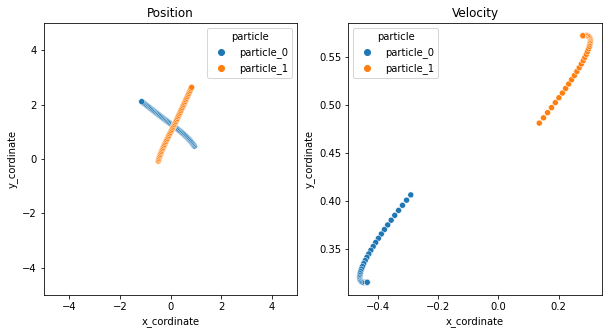

In [7]:


particle_positions = []
for position in simulation_sample.trajectories.positions:
    for particle_id in position.columns:
        particle_positions.append({
            'x_cordinate': position[particle_id]['x_cordinate'],
            'y_cordinate': position[particle_id]['y_cordinate'],
            'particle': particle_id
        })
position_dframe = pd.DataFrame(particle_positions)


particle_velocity = []
for position in simulation_sample.trajectories.velocity:
    for particle_id in position.columns:
        particle_velocity.append({
            'x_cordinate': position[particle_id]['x_cordinate'],
            'y_cordinate': position[particle_id]['y_cordinate'],
            'particle': particle_id
        })
velocity_dframe = pd.DataFrame(particle_velocity)


fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False, sharex=False)
axes[0].set_title('Position')
axes[1].set_title('Velocity')
simulation_sample = train.iloc[0]
pl = sns.scatterplot(data=position_dframe, x='x_cordinate', y='y_cordinate', hue='particle', ax=axes[0])
sns.scatterplot(data=velocity_dframe, x='x_cordinate', y='y_cordinate', hue='particle', ax=axes[1])
pl.set_ylim(-5.0, 5.0)
pl.set_xlim(-5.0, 5.0)

For the same sample trajectory lets plots its enegry graphs

<AxesSubplot:xlabel='time_step', ylabel='total_energy'>

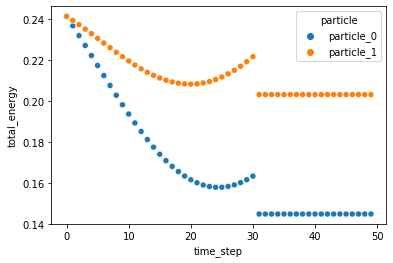

In [10]:
total_energy = []
time_step = 0
for position in simulation_sample.trajectories.total_energy:
    for particle_id in position.columns:
        total_energy.append({
            'total_energy': position[particle_id]['total_energy'],
            'particle': particle_id,
            'time_step': time_step
        })
    time_step += 1
energy_dframe = pd.DataFrame(total_energy)
sns.scatterplot(data=energy_dframe, x='time_step', y='total_energy', hue='particle')

          t-1       t+1
t-1  1.000000  0.995302
t+1  0.995302  1.000000


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

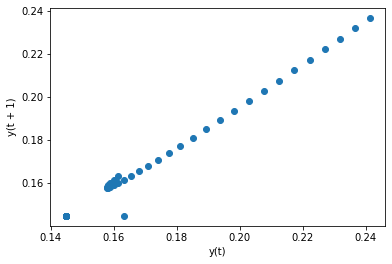

In [12]:
pos = energy_dframe.set_index('time_step')
edf = pos[pos.particle=='particle_0'].total_energy
_df = pd.concat([edf.shift(1), edf], axis=1)
_df.columns = ['t-1', 't+1']
result = _df.corr()
print(result)
from pandas.plotting import lag_plot
lag_plot(edf)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

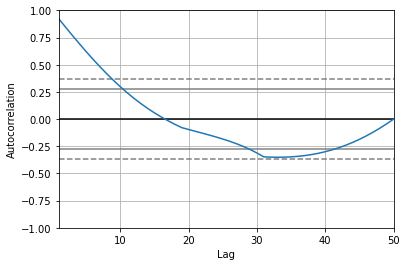

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(edf)

NameError: name 'dataframe' is not defined